In [1]:
from fromscratchtoml.neural_network.models import Sequential
from fromscratchtoml.neural_network.optimizers import StochasticGradientDescent
from fromscratchtoml.neural_network.layers import Dense, Activation

import numpy as np
from sklearn.model_selection import train_test_split

from fromscratchtoml.toolbox.random import Distribution
from fromscratchtoml.toolbox.preprocess import to_onehot

In [2]:
from sklearn import datasets
from sklearn.utils import shuffle

from fromscratchtoml.toolbox import binary_visualize

%matplotlib inline

# Neural Networks

## Fitting a XOR gate

In [3]:
model1 = Sequential()
model1.add(Dense(5, input_dim=2, seed=1))
model1.add(Activation('sigmoid'))
model1.add(Dense(5, seed=2))
model1.add(Activation('sigmoid'))
model1.add(Dense(2, seed=3))
sgd = StochasticGradientDescent(learning_rate=0.1)
model1.compile(optimizer=sgd, loss="mean_squared_error")

In [4]:
X1 = np.array([[0, 0],[0, 1],[1, 0], [1, 1]])
y1 = np.array([[1,0], [0,1], [0,1], [1,0]])
y1

array([[1, 0],
       [0, 1],
       [0, 1],
       [1, 0]])

In [5]:
%time model1.fit(X1, y1, batch_size=4, epochs=100)

[███████████████████████████████████████ ] 99% 
epoch: 100/100  acc: 100.00  loss: 0.000 
[████████████████████████████████████████] 100% CPU times: user 98.4 ms, sys: 8.18 ms, total: 107 ms
Wall time: 168 ms


In [6]:
model1.layers[-1].biases

array([[1.346127  , 2.11858538]])

In [7]:
model1.layers[-1].weights

array([[-1.13710606, -0.4548632 ],
       [-0.46534801, -2.15876972],
       [-0.88261708, -0.40209691],
       [ 1.06302935,  0.20252469],
       [-1.55501902,  0.83763579]])

In [8]:
model1.predict(X1, one_hot=True)

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.]])

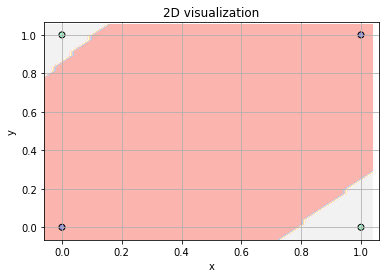

In [9]:
binary_visualize(X1, clf=model1, draw_contour=True)

## MNIST Digit Classification

In [10]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home=".")
print(len(mnist.data))
X2 = mnist.data/256.
y2 = to_onehot(mnist.target)

70000


In [11]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=60000, random_state=42)
X_train2.shape, y_train2.shape

((10000, 784), (10000, 10))

In [12]:
model2 = Sequential(verbose=True)
model2.add(Dense(30, input_dim=784, seed=10))
model2.add(Activation('sigmoid'))
model2.add(Dense(10, seed=10))
model2.add(Activation('sigmoid'))
sgd = StochasticGradientDescent(learning_rate=1)
model2.compile(optimizer=sgd, loss="mean_squared_error")

In [13]:
%time model2.fit(X_train2, y_train2, batch_size=10, epochs=5)


epoch: 1/5  acc: 84.52  loss: 0.031 
[████████                                ] 20% 
epoch: 2/5  acc: 87.81  loss: 0.024 
[████████████████                        ] 40% 
epoch: 3/5  acc: 90.46  loss: 0.019 
[████████████████████████                ] 60% 
epoch: 4/5  acc: 92.02  loss: 0.016 
[████████████████████████████████        ] 80% 
epoch: 5/5  acc: 91.20  loss: 0.018 
[████████████████████████████████████████] 100% CPU times: user 26.4 s, sys: 457 ms, total: 26.9 s
Wall time: 26.3 s


In [14]:
model2.accuracy(X_test2, y_test2)

89.53333333333333

## Training a single perceptron

In [15]:
model3 = Sequential()
model3.add(Dense(1, input_dim=1, seed=10))
model3.add(Activation('sigmoid'))
sgd = StochasticGradientDescent(learning_rate=0.5)
model3.compile(optimizer=sgd, loss="mean_squared_error")

In [16]:
X3 = np.array([1])
y3 = np.array([0.2])

In [17]:
%time model3.fit(X3, y3, epochs=200)

[███████████████████████████████████████ ] 99% 
epoch: 200/200  acc: 100.00  loss: 0.640 
[████████████████████████████████████████] 100% CPU times: user 142 ms, sys: 16.9 ms, total: 159 ms
Wall time: 266 ms


In [18]:
model3.forwardpass(X3)

array([[0.20095324]])

## Iris Dataset

In [19]:
iris = datasets.load_iris()

X4 = iris.data[:, :2]
Y4 = to_onehot(iris.target[:])
X4, Y4 = shuffle(X4, Y4, random_state=10)

Xtrain4 = X4[:120]
Ytrain4 = Y4[:120]
Xtest4 = X4[120:]
Ytest4 = Y4[120:]

In [20]:
model4 = Sequential()
model4.add(Dense(5, input_dim=2, seed=1))
model4.add(Activation('sigmoid'))
model4.add(Dense(3, seed=2))
model4.add(Activation('sigmoid'))
sgd = StochasticGradientDescent(learning_rate=0.1)
model4.compile(optimizer=sgd, loss="mean_squared_error")

In [21]:
%time model4.fit(Xtrain4, Ytrain4, epochs=100)

[███████████████████████████████████████ ] 99% 
epoch: 100/100  acc: 80.83  loss: 0.128 
[████████████████████████████████████████] 100% CPU times: user 833 ms, sys: 33.9 ms, total: 867 ms
Wall time: 894 ms


In [22]:
model4.predict(Xtrain4[:5], one_hot=True), Ytest4[:5]

(array([[0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.]], dtype=float128), array([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.]], dtype=float128))

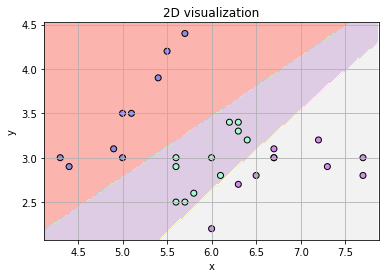

In [23]:
binary_visualize(Xtest4, clf=model4, draw_contour=True)

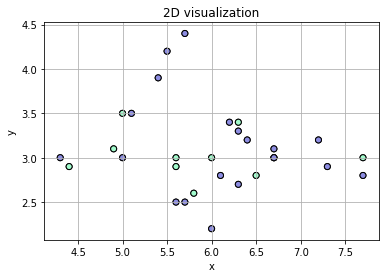

In [24]:
binary_visualize(Xtest4, Ytest4)

## Radial

In [25]:
X11 = Distribution.radial_binary(pts=300,
               mean=[0, 0],
               st=1,
               ed=2, seed=20)
X22 = Distribution.radial_binary(pts=300,
               mean=[0, 0],
               st=4,
               ed=5, seed=20)

Y11 = np.ones(X11.shape[0])
Y22 = np.zeros(X11.shape[0])

X5 = np.vstack((X11, X22))
y5 = np.hstack((Y11, Y22))

In [26]:
y5 = to_onehot(y5)

In [27]:
X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y5, test_size=50, random_state=42)

In [28]:
y_train5.shape

(550, 2)

In [29]:
model5 = Sequential(verbose=1, vis_each_epoch=True)
model5.add(Dense(10, input_dim=2, seed=1))
model5.add(Activation('sigmoid'))
model5.add(Dense(2, seed=2))
model5.add(Activation('sigmoid'))
model5.add(Dense(2, seed=3))
# model5.add(Activation('sigmoid'))
sgd = StochasticGradientDescent(learning_rate=0.05)
model5.compile(optimizer=sgd, loss="mean_squared_error")


epoch: 1/5  acc: 68.00  loss: 0.320 


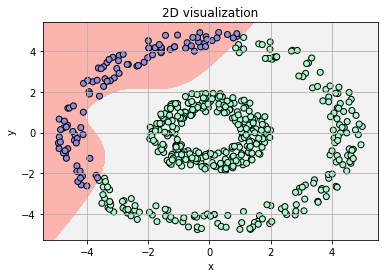

[████████                                ] 20% 
epoch: 2/5  acc: 71.45  loss: 0.285 


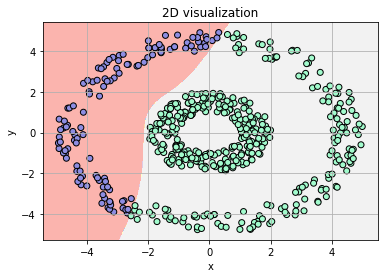

[████████████████                        ] 40% 
epoch: 3/5  acc: 83.09  loss: 0.169 


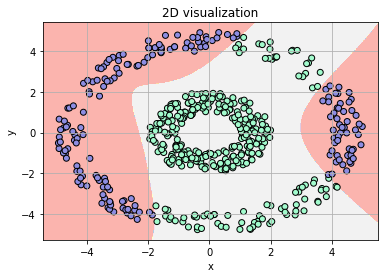

[████████████████████████                ] 60% 
epoch: 4/5  acc: 99.45  loss: 0.005 


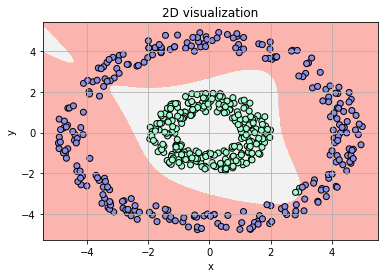

[████████████████████████████████        ] 80% 
epoch: 5/5  acc: 100.00  loss: 0.000 


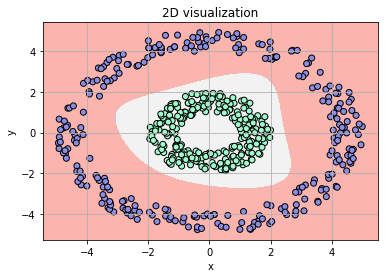

[████████████████████████████████████████] 100% CPU times: user 35.8 s, sys: 1.92 s, total: 37.7 s
Wall time: 35 s


In [30]:
%time model5.fit(X_train5, y_train5, epochs=5)

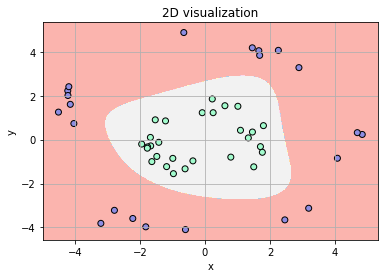

In [31]:
binary_visualize(X_test5, clf=model5, draw_contour=True)